In [ ]:
import sys
sys.path.append('../scripts')

from fugaku_data_preprocessing import preprocess_data
from ml_model_training import train_model_per_cluster, test_model_per_cluster
from baseline_xgboost import train_eagle_xgboost, test_eagle_xgboost
from kmeans_clustering import create_sub_dataframes

# Standard Libraries
import os
import sys
import datetime
from datetime import timedelta

# Data manipulation and numerical operations
import pandas as pd
import numpy as np

# Machine Learning and Model Evaluation
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

# Plotting and Visualization
import matplotlib.pyplot as plt

# Data Preprocessing

In [ ]:
directory = '../data/fugaku/24_04.parquet'
df_success, df_failure, numerical_features = preprocess_data(directory)
print("Preprocessing complete.")
print(f"Number of successful jobs: {len(df_success)}")
print(f"Number of failed jobs: {len(df_failure)}")

Preprocessing complete.
Number of successful jobs: 338760
Number of failed jobs: 81654


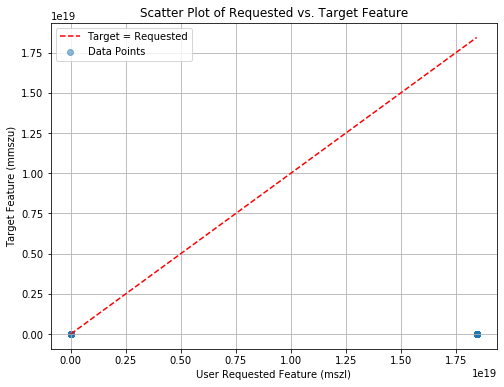

In [3]:
plt.figure(figsize=(8, 6))
plt.scatter(df_success['mszl'], df_success['mmszu'], alpha=0.5, label='Data Points')

# Add reference line where target = requested
min_val = min(df_success['mszl'].min(), df_success['mmszu'].min())
max_val = max(df_success['mszl'].max(), df_success['mmszu'].max())
plt.plot([min_val, max_val], [min_val, max_val], 'r--', label='Target = Requested')

# Labels and title
plt.xlabel('User Requested Feature (mszl)')
plt.ylabel('Target Feature (mmszu)')
plt.title('Scatter Plot of Requested vs. Target Feature')
plt.legend()
plt.grid(True)

# Show plot
plt.show()

# Train-Test Split


In [4]:
start_time = '2024-04-05'
end_time = '2024-04-30'
window_size = 3
update_frequency = '3D'


In [5]:
start_dates = pd.date_range(start=start_time, end=end_time, freq=update_frequency)
end_dates = start_dates + pd.DateOffset(days=window_size)

date_pairs = list(zip(start_dates, end_dates))


In [6]:
train_features = ['jid', 'usr', 'jnam', 'cnumr', 'nnumr', 'elpl', 'mszl', 'freq_req'] # Job ID!!!
target_feature = ['cnumut'] 
target_features = ['duration', 'cnumut', 'mmszu']
user_req_feature = 'cnumr'
req_features = ['elpl', 'cnumr', 'mszl']

bias_types = ['none', 'mean', 'mad', 'std_dev', 'two_sigma']




In [7]:
df = df_success.copy()
df['edt'] = pd.to_datetime(df['edt']).dt.tz_convert(None)




In [ ]:
start_dates

In [ ]:
end_dates

In [8]:
df = df.sort_values(by='adt').reset_index(drop=True)

# Helper Functions

In [9]:
def calculate_accuracy(actual, predicted):
    '''
    Usage:
    
    df['accuracy'] = df.apply(lambda row: calculate_accuracy(row['actual'], row['predicted']), axis=1)
    average_accuracy = df['accuracy'].mean()
    
    '''
    if actual == 0 or predicted == 0:
        return 0 if actual != predicted else 1
    
    if predicted < actual:
        return predicted / actual
    else:
        return actual / predicted
    

In [10]:
def calculate_ur(actual, predicted):
    underpredictions = sum(predicted < actual)
    total_predictions = len(actual)
    ur = underpredictions / total_predictions if total_predictions > 0 else 0
    return ur
    

In [11]:
def create_clusters(df, selected_features, n_clusters):
    df_copy = df.copy()
    
    feature_data = df[selected_features].replace([np.inf, -np.inf], np.nan).fillna(df.mean(numeric_only=True))
    scaler = StandardScaler()
    feature_data_scaled = feature_data.values  

    kmeans = KMeans(n_clusters=n_clusters,  init='k-means++', random_state=42)
    
    df_copy.loc[:, 'cluster'] = kmeans.fit_predict(feature_data_scaled)
    
    
    cluster_centers = kmeans.cluster_centers_
    
    sub_dataframes = [df_copy[df_copy['cluster'] == cluster].drop(columns=['cluster']) for cluster in range(n_clusters)]
    
    return sub_dataframes, cluster_centers


In [12]:
def make_prediction(test_df, train_features, target_feature, user_req_feature, cluster_centers, models, biases, bias_type='two_sigma'):
    
    test_features = test_df[train_features].values
    distances = np.linalg.norm(cluster_centers[:, np.newaxis] - test_features, axis=2)
    
    test_df.loc[:, 'cluster'] = np.argmin(distances, axis=0)


    pred_vs_act_df = pd.DataFrame(columns=['pred', 'act', 'req'])

    for cluster_id, (model, bias_dict) in enumerate(zip(models, biases)):
        cluster_data = test_df[test_df['cluster'] == cluster_id]
        cluster_data = cluster_data.replace([np.inf, -np.inf], np.nan).dropna()
        

        if not cluster_data.empty:
            X_test = cluster_data[train_features].values
            y_test = cluster_data[target_feature].values

            y_pred = model.predict(X_test)

            if bias_type != 'none':
                # Select the appropriate bias based on the specified bias type
                bias = bias_dict.get(bias_type, 0.0) 
                y_pred = y_pred + bias               
            else:
                y_pred = y_pred
            
            y_pred = np.array(y_pred).flatten()
            y_test = np.array(y_test).flatten()

            
            user_req = cluster_data[user_req_feature].values
            user_req = np.array(user_req).flatten()
            new_df = pd.DataFrame({
                'pred': y_pred,
                'act': y_test,
                'req': user_req
            })
    
            pred_vs_act_df = pd.concat([pred_vs_act_df, new_df], ignore_index=True)
    return pred_vs_act_df



In [13]:
from sklearn.utils import resample

def resample_train_data(train_df, target_feature, n_bins=10, random_state=42):

    df = train_df.copy()
    

    target_values = df[target_feature].values
    

    bins = np.linspace(target_values.min(), target_values.max(), n_bins + 1)
    bin_indices = np.digitize(target_values, bins) - 1
    bin_indices = np.clip(bin_indices, 0, n_bins - 1)
    

    bin_counts = np.bincount(bin_indices)
    max_bin_size = max(bin_counts)
    
    resampled_dfs = []
    
    for bin_idx in range(n_bins):
        bin_mask = bin_indices == bin_idx
        bin_samples = df[bin_mask]
        
        # Skip empty bins
        if len(bin_samples) == 0:
            continue
            
        # Only resample if necessary
        if len(bin_samples) < max_bin_size:
            # Upsample the bin to match the size of the largest bin
            resampled_bin = resample(
                bin_samples,
                replace=True,
                n_samples=max_bin_size,
                random_state=random_state
            )
            resampled_dfs.append(resampled_bin)
        else:
            # No need to resample if already at maximum size
            resampled_dfs.append(bin_samples)
    
    # Combine all resampled bins
    balanced_df = pd.concat(resampled_dfs, ignore_index=True)
    
    return balanced_df

In [14]:
def plot_target_distribution(original_df, resampled_df, target_feature, bins=30, figsize=(14, 6)):

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=figsize)
    
    min_val = min(original_df[target_feature].min(), resampled_df[target_feature].min())
    max_val = max(original_df[target_feature].max(), resampled_df[target_feature].max())
    bin_range = np.linspace(min_val, max_val, bins+1)
    
    sns.histplot(original_df[target_feature], bins=bin_range, kde=True, ax=ax1, color='blue')
    ax1.set_title('Original Distribution')
    ax1.set_xlabel(target_feature)
    ax1.set_ylabel('Frequency')
    
    sns.histplot(resampled_df[target_feature], bins=bin_range, kde=True, ax=ax2, color='green')
    ax2.set_title('Resampled Distribution')
    ax2.set_xlabel(target_feature)
    ax2.set_ylabel('Frequency')
    
    orig_mean = original_df[target_feature].mean()
    orig_median = original_df[target_feature].median()
    orig_std = original_df[target_feature].std()
    
    resampled_mean = resampled_df[target_feature].mean()
    resampled_median = resampled_df[target_feature].median()
    resampled_std = resampled_df[target_feature].std()
    
    ax1.axvline(orig_mean, color='red', linestyle='--', label=f'Mean: {orig_mean:.2f}')
    ax1.axvline(orig_median, color='black', linestyle='-', label=f'Median: {orig_median:.2f}')
    ax1.legend()
    
    ax2.axvline(resampled_mean, color='red', linestyle='--', label=f'Mean: {resampled_mean:.2f}')
    ax2.axvline(resampled_median, color='black', linestyle='-', label=f'Median: {resampled_median:.2f}')
    ax2.legend()
    
    plt.tight_layout()
    plt.show()
    
    print(f"Original Distribution - Mean: {orig_mean:.2f}, Median: {orig_median:.2f}, Std: {orig_std:.2f}")
    print(f"Resampled Distribution - Mean: {resampled_mean:.2f}, Median: {resampled_median:.2f}, Std: {resampled_std:.2f}")
    

In [15]:
import time

def time_model(func):
    def wrapper(*args, **kwargs):
        # Start timing for training
        train_start = time.time()
        model = func(*args, **kwargs)
        train_end = time.time()
        training_time = train_end - train_start
        
        # Return model and training time
        return model, training_time
    return wrapper

@time_model
def train_single_model(X_train, y_train, random_state=33):
    model = RandomForestRegressor(random_state=random_state)
    model.fit(X_train, y_train)
    return model

In [28]:
def convert_fugaku_to_swf(df):
    swf_df = pd.DataFrame()
    
    df = df.sort_values(by='adt').reset_index(drop=True)
    swf_df['Job Number'] = range(1, len(df) + 1)

    
    df['adt'] = pd.to_datetime(df['adt'], errors='coerce') 
    df['adt'] = df['adt'].dropna().astype('int64') // 10**9   # datetime converts to nanoseconds passed since 1970-01-01
    min_submit_time = df['adt'].min()
    swf_df['Submit Time'] = df['adt'] - min_submit_time
    

    swf_df['Wait Time'] = -1
    swf_df['Run Time'] = df['duration'].fillna(-1)
    

    swf_df['Number of Allocated Processors'] = df['cnumr'].fillna(-1)
    

    swf_df['Average CPU Time Used'] = (df['usctmut'].fillna(0) / df['cnumat'].replace(0, np.nan)).fillna(-1)
    
    swf_df['Used Memory'] = df['mmszu'].fillna(-1)
    swf_df['Requested Number of Processors'] = df['cnumr'].fillna(-1)
    swf_df['Requested Time'] = df['elpl'].fillna(-1)
    swf_df['Requested Memory'] = df['mszl'].fillna(-1)
    
    status_mapping = {'completed': 1, 'FAILED': 0, 'CANCELLED': 5}
    swf_df['Status'] = df['exit state'].map(status_mapping).fillna(-1)
    
    user_mapping = {user: idx + 1 for idx, user in enumerate(df['usr'].unique())}
    swf_df['User ID'] = df['usr'].map(user_mapping).fillna(-1)
    
    swf_df['Group ID'] = -1
    
    # Executable (Application) Number (mapping job names to IDs)
    app_mapping = {app: idx + 1 for idx, app in enumerate(df['jnam'].unique())}
    swf_df['Executable (Application) Number'] = df['jnam'].map(app_mapping).fillna(-1)
    

    swf_df['Queue Number'] = -1  # No info
    swf_df['Partition Number'] = -1  # No info
    swf_df['Preceding Job Number'] = -1  # No info
    swf_df['Think Time from Preceding Job'] = -1  # No info
    
    return swf_df

In [17]:
def save_swf(swf_df, num_proc, num_nodes, filename="output.swf"):
    with open(filename, "w") as f:
        f.write(f"; MaxNodes: {num_nodes}\n")
        f.write(f"; MaxProcs: {num_proc}\n")
        
        swf_df.to_csv(f, sep=" ", index=False, header=False)

# Multiple Output Prediction Experiment

In [ ]:
from sklearn.ensemble import ExtraTreesRegressor

multiple_model_predictions = pd.DataFrame()
single_model_predictions = pd.DataFrame()

for start_date, end_date in date_pairs:
    
    df_slice = df[(df['edt'] >= start_date) & (df['edt'] < end_date)]
    train_df, test_df = train_test_split(df_slice, test_size=0.2, random_state=33, shuffle=False)

    
    X_train = train_df[train_features]
    y_train = train_df[target_features]

    X_test = test_df[train_features]
    y_test = test_df[target_features]
    y_req = test_df[req_features]


    model = RandomForestRegressor(random_state=33)
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)
    
    
    pred_vs_act_df = pd.DataFrame()
    pred_vs_act_df['time_pred'] = y_pred[:, 0]
    pred_vs_act_df['time_act'] = y_test['duration'].values
    pred_vs_act_df['time_req'] = y_req['elpl'].values
    pred_vs_act_df['cpu_pred'] = y_pred[:, 1]
    pred_vs_act_df['cpu_act'] = y_test['cnumut'].values
    pred_vs_act_df['cpu_req'] = y_req['cnumr'].values
    pred_vs_act_df['mem_pred'] = y_pred[:, 2]
    pred_vs_act_df['mem_act'] = y_test['mmszu'].values
    pred_vs_act_df['mem_req'] = y_req['mszl'].values
    
    multiple_model_predictions = pd.concat([multiple_model_predictions, pred_vs_act_df], ignore_index=True)
    

    
    y_train = train_df['duration']
    model = RandomForestRegressor(random_state=33)
    model.fit(X_train,y_train)
    time_pred = model.predict(X_test)


    y_train = train_df['cnumut']
    model = RandomForestRegressor(random_state=33)
    model.fit(X_train,y_train)
    cpu_pred = model.predict(X_test)


    y_train = train_df['mmszu']
    model = RandomForestRegressor(random_state=33)
    model.fit(X_train,y_train)
    mem_pred = model.predict(X_test)
    
    
    pred_vs_act_df = pd.DataFrame()

    pred_vs_act_df['time_pred'] = time_pred
    pred_vs_act_df['time_act'] = test_df['duration'].values
    pred_vs_act_df['time_req'] = test_df['elpl'].values
    pred_vs_act_df['cpu_pred'] = cpu_pred
    pred_vs_act_df['cpu_act'] = test_df['cnumut'].values
    pred_vs_act_df['cpu_req'] = test_df['cnumr'].values
    pred_vs_act_df['mem_pred'] = mem_pred
    pred_vs_act_df['mem_act'] = test_df['mmszu'].values
    pred_vs_act_df['mem_req'] = test_df['mszl'].values
    
    single_model_predictions = pd.concat([single_model_predictions, pred_vs_act_df], ignore_index=True)

   
    
    
    

In [ ]:
df_success['jid'].value_counts()



# Clustering Accuracy Experiment

/project/peaclab-mon/monitoring_venv/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
/project/peaclab-mon/monitoring_venv/lib/python3.6/site-packages/matplotlib/axes/_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
/project/peaclab-mon/monitoring_venv/lib/python3.6/site-packages/matplotlib/axes/_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]
/project/peaclab-mon/monitoring_venv/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:1402: Futur

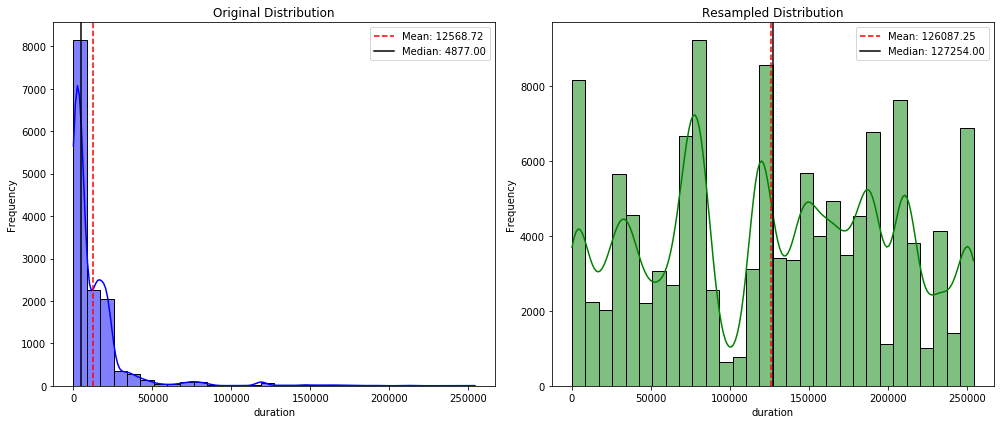

Original Distribution - Mean: 12568.72, Median: 4877.00, Std: 21904.72
Resampled Distribution - Mean: 126087.25, Median: 127254.00, Std: 74323.19


/project/peaclab-mon/monitoring_venv/lib/python3.6/site-packages/pandas/core/indexing.py:1596: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/project/peaclab-mon/monitoring_venv/lib/python3.6/site-packages/pandas/core/indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)
/project/peaclab-mon/monitoring_venv/lib/python3.6/site-packages/pandas/core/indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a s

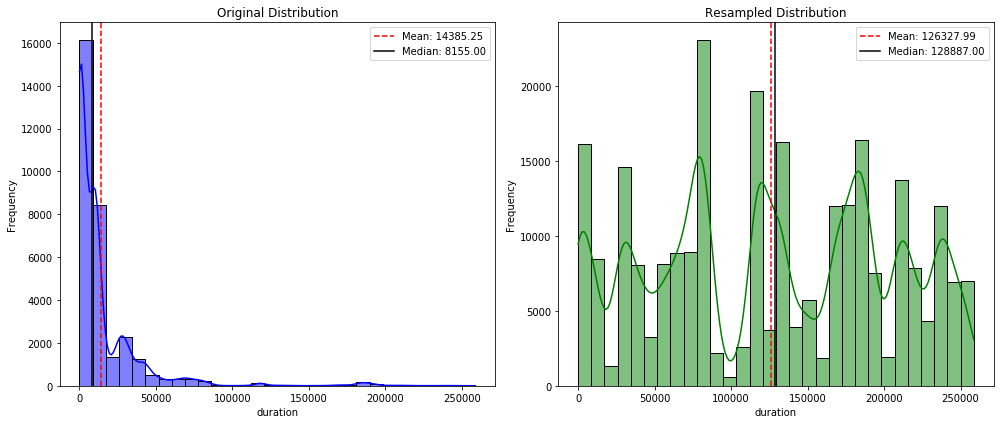

Original Distribution - Mean: 14385.25, Median: 8155.00, Std: 26374.99
Resampled Distribution - Mean: 126327.99, Median: 128887.00, Std: 75584.04


/project/peaclab-mon/monitoring_venv/lib/python3.6/site-packages/pandas/core/indexing.py:1596: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/project/peaclab-mon/monitoring_venv/lib/python3.6/site-packages/pandas/core/indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)
/project/peaclab-mon/monitoring_venv/lib/python3.6/site-packages/pandas/core/indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a s

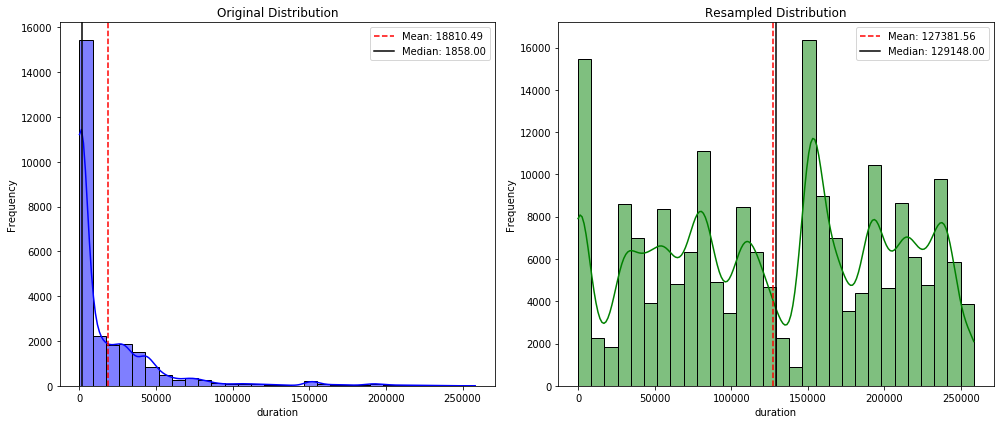

Original Distribution - Mean: 18810.49, Median: 1858.00, Std: 33570.48
Resampled Distribution - Mean: 127381.56, Median: 129148.00, Std: 75750.80


/project/peaclab-mon/monitoring_venv/lib/python3.6/site-packages/pandas/core/indexing.py:1596: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/project/peaclab-mon/monitoring_venv/lib/python3.6/site-packages/pandas/core/indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)
/project/peaclab-mon/monitoring_venv/lib/python3.6/site-packages/pandas/core/indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a s

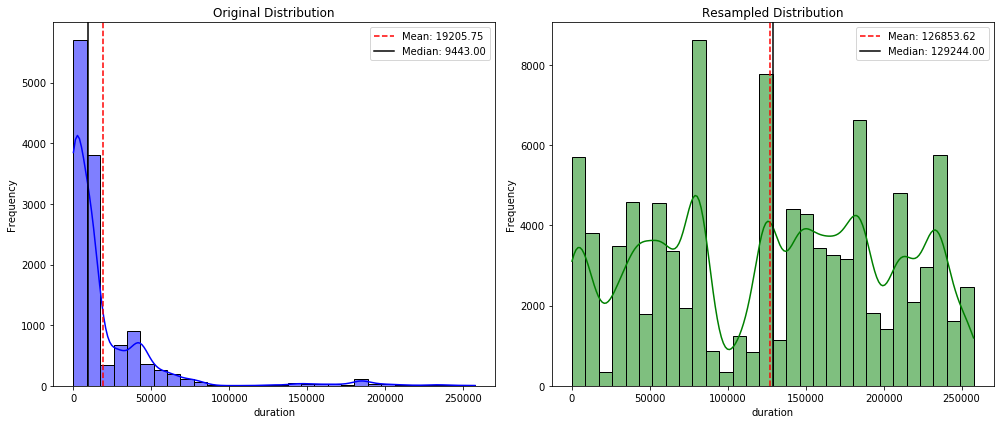

Original Distribution - Mean: 19205.75, Median: 9443.00, Std: 34660.15
Resampled Distribution - Mean: 126853.62, Median: 129244.00, Std: 75115.33


/project/peaclab-mon/monitoring_venv/lib/python3.6/site-packages/pandas/core/indexing.py:1596: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/project/peaclab-mon/monitoring_venv/lib/python3.6/site-packages/pandas/core/indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)
/project/peaclab-mon/monitoring_venv/lib/python3.6/site-packages/pandas/core/indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a s

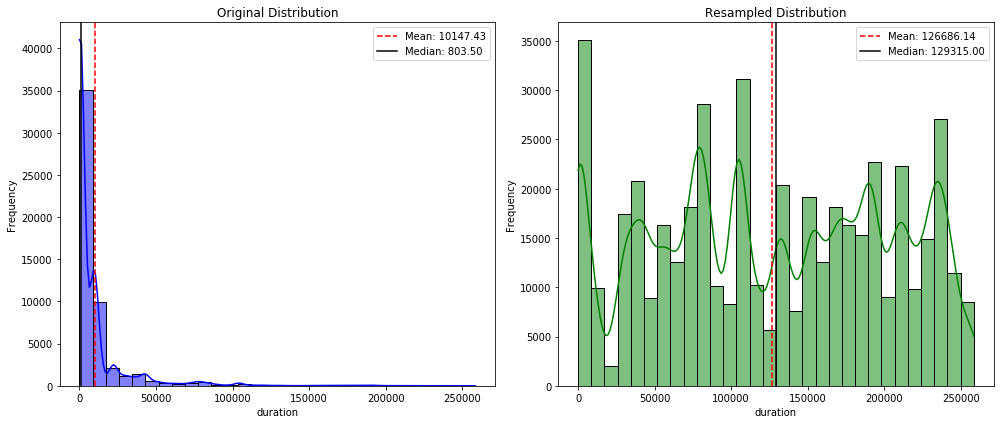

Original Distribution - Mean: 10147.43, Median: 803.50, Std: 23033.27
Resampled Distribution - Mean: 126686.14, Median: 129315.00, Std: 75743.15


/project/peaclab-mon/monitoring_venv/lib/python3.6/site-packages/pandas/core/indexing.py:1596: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/project/peaclab-mon/monitoring_venv/lib/python3.6/site-packages/pandas/core/indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)
/project/peaclab-mon/monitoring_venv/lib/python3.6/site-packages/pandas/core/indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a s

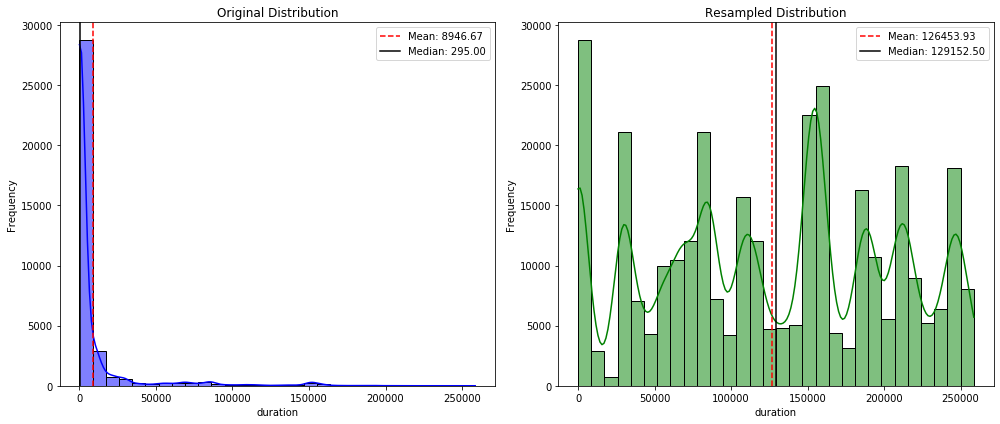

Original Distribution - Mean: 8946.67, Median: 295.00, Std: 26990.26
Resampled Distribution - Mean: 126453.93, Median: 129152.50, Std: 76462.21


/project/peaclab-mon/monitoring_venv/lib/python3.6/site-packages/pandas/core/indexing.py:1596: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/project/peaclab-mon/monitoring_venv/lib/python3.6/site-packages/pandas/core/indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)
/project/peaclab-mon/monitoring_venv/lib/python3.6/site-packages/pandas/core/indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a s

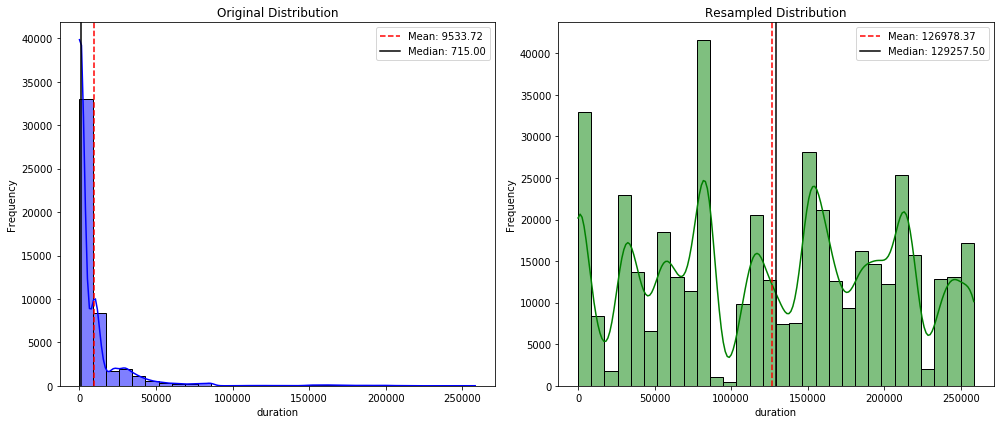

Original Distribution - Mean: 9533.72, Median: 715.00, Std: 22591.38
Resampled Distribution - Mean: 126978.37, Median: 129257.50, Std: 76641.03


/project/peaclab-mon/monitoring_venv/lib/python3.6/site-packages/pandas/core/indexing.py:1596: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/project/peaclab-mon/monitoring_venv/lib/python3.6/site-packages/pandas/core/indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)
/project/peaclab-mon/monitoring_venv/lib/python3.6/site-packages/pandas/core/indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a s

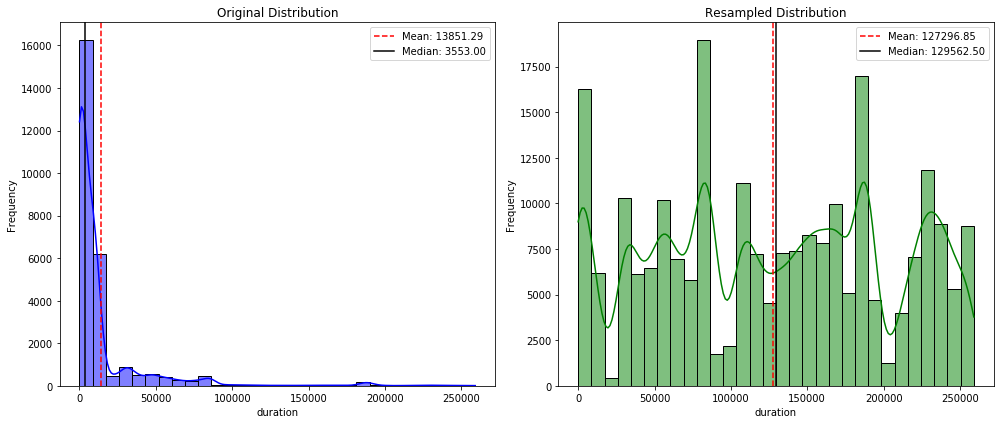

Original Distribution - Mean: 13851.29, Median: 3553.00, Std: 30174.37
Resampled Distribution - Mean: 127296.85, Median: 129562.50, Std: 76528.97


/project/peaclab-mon/monitoring_venv/lib/python3.6/site-packages/pandas/core/indexing.py:1596: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/project/peaclab-mon/monitoring_venv/lib/python3.6/site-packages/pandas/core/indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)
/project/peaclab-mon/monitoring_venv/lib/python3.6/site-packages/pandas/core/indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a s

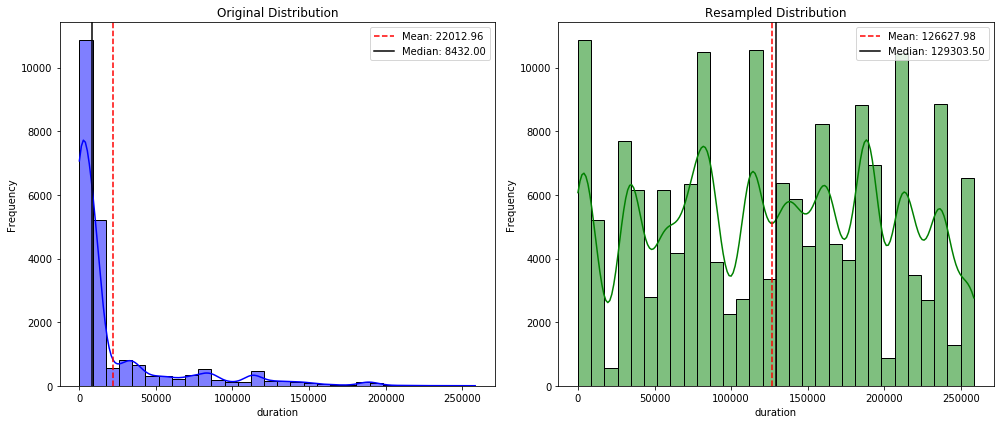

Original Distribution - Mean: 22012.96, Median: 8432.00, Std: 38742.90
Resampled Distribution - Mean: 126627.98, Median: 129303.50, Std: 75243.45


/project/peaclab-mon/monitoring_venv/lib/python3.6/site-packages/pandas/core/indexing.py:1596: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/project/peaclab-mon/monitoring_venv/lib/python3.6/site-packages/pandas/core/indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)
/project/peaclab-mon/monitoring_venv/lib/python3.6/site-packages/pandas/core/indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a s

TypeError: 'numpy.bool_' object is not iterable

In [18]:
bias_type = 'two_sigma'
single_no_resample = pd.DataFrame()
single_yes_resample = pd.DataFrame()
multi_no_resample = pd.DataFrame()
multi_yes_resample = pd.DataFrame()



for target in target_features:
    
    for start_date, end_date in date_pairs:

        df_slice = df[(df['edt'] >= start_date) & (df['edt'] < end_date)]
        train_df, test_df = train_test_split(df_slice, test_size=0.2, random_state=33)
        
        X_train = train_df[train_features]
        y_train = train_df[target]

        X_test = test_df[train_features]
        y_test = test_df[target]

        # Single Model Training - Without Resampling
        model = XGBRegressor(random_state=33)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        pred_df = pd.DataFrame()
        pred_df['act'] = test_df[target].values
        pred_df['pred'] = y_pred
        
        single_no_resample = pd.concat([single_no_resample, pred_df], ignore_index=True)
        
        
        # Single Model Training - With Resampling
        model = XGBRegressor(random_state=33)
        balanced_train = resample_train_data(train_df, target)
        model.fit(balanced_train[train_features], balanced_train[target])
        y_pred = model.predict(X_test)
        pred_df = pd.DataFrame()
        pred_df['act'] = test_df[target].values
        pred_df['pred'] = y_pred
        
        single_yes_resample = pd.concat([single_yes_resample, pred_df], ignore_index=True)
        
        plot_target_distribution(train_df, balanced_train, target)
        plt.show()
        
        
        # Clustering
        sub_dataframes, cluster_centers = create_clusters(
            df=train_df, 
            selected_features=train_features, 
            n_clusters=3 #!!!!!!!!!! 
        )
        
        
        # No resampling
        rf_plain_models, rf_plain_biases = train_model_per_cluster(
            sub_dataframes, train_features, target, 'xgboost')
        
        pred_df = pd.DataFrame()
        pred_df = make_prediction(
            test_df, train_features, target, user_req_feature, cluster_centers,
            rf_plain_models, rf_plain_biases, bias_type)
            
        multi_no_resample = pd.concat([multi_no_resample, pred_df], ignore_index=True)
    
    
    
        # Resampling
        rf_resampled_models, rf_resampled_biases = train_model_per_cluster(
            sub_dataframes, train_features, target, 'xgboost',resampling=True)
        
        pred_df = pd.DataFrame()
        pred_df = make_prediction(
            test_df, train_features, target, user_req_feature, cluster_centers,
            rf_resampled_models, rf_resampled_biases, bias_type)
            
        multi_yes_resample = pd.concat([multi_yes_resample, pred_df], ignore_index=True)
        
        
        
    single_no_resample['accuracy'] = single_no_resample.apply(lambda row: calculate_accuracy(row['act'], row['pred']), axis=1)
    acc = single_no_resample['accuracy'].mean()
    single_no_resample['ur'] = single_no_resample.apply(lambda row: calculate_ur(row['act'], row['pred']), axis=1)

    print(f"Single Model - No Resampling ---- Feature: {target}, Bias: {bias_type}, Accuracy: {acc}, UR: {single_no_resample['ur']}")
    
          
          
    single_yes_resample['accuracy'] = single_yes_resample.apply(lambda row: calculate_accuracy(row['act'], row['pred']), axis=1)
    acc = single_yes_resample['accuracy'].mean()
    single_yes_resample['ur'] = single_yes_resample.apply(lambda row: calculate_ur(row['act'], row['pred']), axis=1)

    print(f"Single Model - With Resampling ---- Feature: {target}, Bias: {bias_type}, Accuracy: {acc}, UR: {single_yes_resample['ur']}")
    
          
    
    multi_no_resample['accuracy'] = multi_no_resample.apply(lambda row: calculate_accuracy(row['act'], row['pred']), axis=1)
    acc = multi_no_resample['accuracy'].mean()
    multi_no_resample['ur'] = multi_no_resample.apply(lambda row: calculate_ur(row['act'], row['pred']), axis=1)

    print(f"Clustering - No Resampling ---- Feature: {target}, Bias: {bias_type}, Accuracy: {acc}, UR: {multi_no_resample['ur']}")
    
          
          
    multi_yes_resample['accuracy'] = multi_yes_resample.apply(lambda row: calculate_accuracy(row['act'], row['pred']), axis=1)
    acc = multi_yes_resample['accuracy'].mean()
    multi_yes_resample['ur'] = multi_yes_resample.apply(lambda row: calculate_ur(row['act'], row['pred']), axis=1)

    print(f"Clustering - With Resampling ---- Feature: {target}, Bias: {bias_type}, Accuracy: {acc}, UR: {multi_yes_resample['ur']}")
    
          
        
        

In [19]:
results = {
    'single_no_resample': [],
    'single_yes_resample': [],
    'multi_no_resample': [],
    'multi_yes_resample': []
}

bias_type = 'two_sigma'


df_dict = {
    'duration': {
        'single_no_resample': None,
        'single_yes_resample': None,
        'multi_no_resample': None,
        'multi_yes_resample': None
    },
    'cnumut': {
        'single_no_resample': None,
        'single_yes_resample': None,
        'multi_no_resample': None,
        'multi_yes_resample': None
    },
    'mmszu': {
        'single_no_resample': None,
        'single_yes_resample': None,
        'multi_no_resample': None,
        'multi_yes_resample': None
    }
}



timing_results = {}

for target in target_features:
    timing_results[target] = {
        'single_no_resample': {'train_time': 0, 'inference_time': 0, 'accuracy': 0, 'ur': 0},
        'single_yes_resample': {'train_time': 0, 'inference_time': 0, 'accuracy': 0, 'ur': 0},
        'multi_no_resample': {'train_time': 0, 'inference_time': 0, 'accuracy': 0, 'ur': 0},
        'multi_yes_resample': {'train_time': 0, 'inference_time': 0, 'accuracy': 0, 'ur': 0}
    }
    
    experiment_count = 0
    
    single_no_resample = pd.DataFrame()
    single_yes_resample = pd.DataFrame()
    multi_no_resample = pd.DataFrame()
    multi_yes_resample = pd.DataFrame()

    for start_date, end_date in date_pairs:
        experiment_count += 1
        
        df_slice = df[(df['edt'] >= start_date) & (df['edt'] < end_date)]
        train_df, test_df = train_test_split(df_slice, test_size=0.2, random_state=33)
        
        X_train = train_df[train_features]
        y_train = train_df[target]

        X_test = test_df[train_features]
        y_test = test_df[target]

        # Single Model Training - Without Resampling
        model, train_time = train_single_model(X_train, y_train)
        
        # Time inference
        inference_start = time.time()
        y_pred = model.predict(X_test)
        inference_end = time.time()
        inference_time = inference_end - inference_start
        
        # Update timing results
        timing_results[target]['single_no_resample']['train_time'] += train_time
        timing_results[target]['single_no_resample']['inference_time'] += inference_time
        
        pred_df = pd.DataFrame()
        pred_df['act'] = test_df[target].values
        pred_df['pred'] = y_pred
        
        single_no_resample = pd.concat([single_no_resample, pred_df], ignore_index=True)
        
        # Single Model Training - With Resampling
        balanced_train = resample_train_data(train_df, target)
        
        # Time training with resampling
        resampled_train_start = time.time()
        model = RandomForestRegressor(random_state=33)
        model.fit(balanced_train[train_features], balanced_train[target])
        resampled_train_end = time.time()
        resampled_train_time = resampled_train_end - resampled_train_start
        
        # Time inference
        resampled_inference_start = time.time()
        y_pred = model.predict(X_test)
        resampled_inference_end = time.time()
        resampled_inference_time = resampled_inference_end - resampled_inference_start
        
        # Update timing results
        timing_results[target]['single_yes_resample']['train_time'] += resampled_train_time
        timing_results[target]['single_yes_resample']['inference_time'] += resampled_inference_time
        
        pred_df = pd.DataFrame()
        pred_df['act'] = test_df[target].values
        pred_df['pred'] = y_pred
        
        single_yes_resample = pd.concat([single_yes_resample, pred_df], ignore_index=True)
        
        
        # Clustering
        cluster_start_time = time.time()
        sub_dataframes, cluster_centers = create_clusters(
            df=train_df, 
            selected_features=train_features, 
            n_clusters=3
        )
        cluster_end_time = time.time()
        clustering_time = cluster_end_time - cluster_start_time
        
        # No resampling with clustering
        multi_train_start = time.time()
        rf_plain_models, rf_plain_biases = train_model_per_cluster(
            sub_dataframes, train_features, target, 'rf')
        multi_train_end = time.time()
        multi_train_time = multi_train_end - multi_train_start
        
        multi_inference_start = time.time()
        pred_df = make_prediction(
            test_df, train_features, target, user_req_feature, cluster_centers,
            rf_plain_models, rf_plain_biases, bias_type)
        multi_inference_end = time.time()
        multi_inference_time = multi_inference_end - multi_inference_start
        
        # Update timing results
        timing_results[target]['multi_no_resample']['train_time'] += (clustering_time + multi_train_time)
        timing_results[target]['multi_no_resample']['inference_time'] += multi_inference_time
            
        multi_no_resample = pd.concat([multi_no_resample, pred_df], ignore_index=True)
    
        # Resampling with clustering
        multi_resampled_train_start = time.time()
        rf_resampled_models, rf_resampled_biases = train_model_per_cluster(
            sub_dataframes, train_features, target, 'rf', resampling=True)
        multi_resampled_train_end = time.time()
        multi_resampled_train_time = multi_resampled_train_end - multi_resampled_train_start
        
        multi_resampled_inference_start = time.time()
        pred_df = make_prediction(
            test_df, train_features, target, user_req_feature, cluster_centers,
            rf_resampled_models, rf_resampled_biases, bias_type)
        multi_resampled_inference_end = time.time()
        multi_resampled_inference_time = multi_resampled_inference_end - multi_resampled_inference_start
        
        # Update timing results
        timing_results[target]['multi_yes_resample']['train_time'] += (clustering_time + multi_resampled_train_time)
        timing_results[target]['multi_yes_resample']['inference_time'] += multi_resampled_inference_time
            
        multi_yes_resample = pd.concat([multi_yes_resample, pred_df], ignore_index=True)
        
        
        
    
    # Calculate metrics for each approach
    single_no_resample['accuracy'] = single_no_resample.apply(lambda row: calculate_accuracy(row['act'], row['pred']), axis=1)
    acc = single_no_resample['accuracy'].mean()
    ur = calculate_ur(single_no_resample['act'].values, single_no_resample['pred'].values)
                    
    # Store results for the target
    timing_results[target]['single_no_resample']['accuracy'] = acc
    timing_results[target]['single_no_resample']['ur'] = ur
    
    print(f"Single Model - No Resampling ---- Feature: {target}, Bias: {bias_type}, Accuracy: {acc}, UR: {ur}")
    
    single_yes_resample['accuracy'] = single_yes_resample.apply(lambda row: calculate_accuracy(row['act'], row['pred']), axis=1)
    acc = single_yes_resample['accuracy'].mean()
    ur = calculate_ur(single_yes_resample['act'].values, single_yes_resample['pred'].values)
    
    # Store results for the target
    timing_results[target]['single_yes_resample']['accuracy'] = acc
    timing_results[target]['single_yes_resample']['ur'] = ur

    print(f"Single Model - With Resampling ---- Feature: {target}, Bias: {bias_type}, Accuracy: {acc}, UR: {ur}")
    
    multi_no_resample['accuracy'] = multi_no_resample.apply(lambda row: calculate_accuracy(row['act'], row['pred']), axis=1)
    acc = multi_no_resample['accuracy'].mean()
    ur = calculate_ur(multi_no_resample['act'].values, multi_no_resample['pred'].values)
    
    # Store results for the target
    timing_results[target]['multi_no_resample']['accuracy'] = acc
    timing_results[target]['multi_no_resample']['ur'] = ur

    print(f"Clustering - No Resampling ---- Feature: {target}, Bias: {bias_type}, Accuracy: {acc}, UR: {ur}")
    
    multi_yes_resample['accuracy'] = multi_yes_resample.apply(lambda row: calculate_accuracy(row['act'], row['pred']), axis=1)
    acc = multi_yes_resample['accuracy'].mean()
    ur = calculate_ur(multi_yes_resample['act'].values, multi_yes_resample['pred'].values)
                    
    # Store results for the target
    timing_results[target]['multi_yes_resample']['accuracy'] = acc
    timing_results[target]['multi_yes_resample']['ur'] = ur

    print(f"Clustering - With Resampling ---- Feature: {target}, Bias: {bias_type}, Accuracy: {acc}, UR: {ur}")
    
    # Calculate average times by dividing by the number of experiments
    '''
    for model_type in timing_results[target]:
        timing_results[target][model_type]['train_time'] /= experiment_count
        timing_results[target][model_type]['inference_time'] /= experiment_count
    '''
    
    df_dict[target] = {
    'single_no_resample': single_no_resample.copy(),
    'single_yes_resample': single_yes_resample.copy(),
    'multi_no_resample': multi_no_resample.copy(),
    'multi_yes_resample': multi_yes_resample.copy()
    }




/project/peaclab-mon/monitoring_venv/lib/python3.6/site-packages/pandas/core/indexing.py:1596: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/project/peaclab-mon/monitoring_venv/lib/python3.6/site-packages/pandas/core/indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)
/project/peaclab-mon/monitoring_venv/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/project/

/project/peaclab-mon/monitoring_venv/lib/python3.6/site-packages/pandas/core/indexing.py:1596: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/project/peaclab-mon/monitoring_venv/lib/python3.6/site-packages/pandas/core/indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)
/project/peaclab-mon/monitoring_venv/lib/python3.6/site-packages/pandas/core/indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a s

Single Model - No Resampling ---- Feature: duration, Bias: two_sigma, Accuracy: 0.9014759361111394, UR: 0.47834090436744753
Single Model - With Resampling ---- Feature: duration, Bias: two_sigma, Accuracy: 0.9012263128069857, UR: 0.4699088506873311
Clustering - No Resampling ---- Feature: duration, Bias: two_sigma, Accuracy: 0.3352125856896949, UR: 0.014221668002731511
Clustering - With Resampling ---- Feature: duration, Bias: two_sigma, Accuracy: 0.5496299154136016, UR: 0.042011816751284105


/project/peaclab-mon/monitoring_venv/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/project/peaclab-mon/monitoring_venv/lib/python3.6/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/project/peaclab-mon/monitoring_venv/lib/python3.6/site-packages/numpy/core/_methods.py:234: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/project/peaclab-mon/monitoring_venv/lib/python3.6/site-packages/numpy/core/_methods.py:195: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/project/peaclab-mon/monitoring_venv/lib/python3.6/site-packages/numpy/core/_methods.py:226: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/project/peaclab-mon/monitoring_venv/lib/python3.6/site-packages/pandas/core/indexing.py

/project/peaclab-mon/monitoring_venv/lib/python3.6/site-packages/pandas/core/indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)
/project/peaclab-mon/monitoring_venv/lib/python3.6/site-packages/pandas/core/indexing.py:1596: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/project/peaclab-mon/monitoring_venv/lib/python3.6/site-packages/pandas/core/indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a s

Single Model - No Resampling ---- Feature: cnumut, Bias: two_sigma, Accuracy: 0.991936343865619, UR: 0.10412398681749355
Single Model - With Resampling ---- Feature: cnumut, Bias: two_sigma, Accuracy: 0.9919193818163694, UR: 0.10361925120988094
Clustering - No Resampling ---- Feature: cnumut, Bias: two_sigma, Accuracy: 0.300842299764033, UR: 0.0020931682550993144
Clustering - With Resampling ---- Feature: cnumut, Bias: two_sigma, Accuracy: 0.455471355155861, UR: 0.0052254980552833945


/project/peaclab-mon/monitoring_venv/lib/python3.6/site-packages/pandas/core/indexing.py:1596: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/project/peaclab-mon/monitoring_venv/lib/python3.6/site-packages/pandas/core/indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)
/project/peaclab-mon/monitoring_venv/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/project/

/project/peaclab-mon/monitoring_venv/lib/python3.6/site-packages/pandas/core/indexing.py:1596: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/project/peaclab-mon/monitoring_venv/lib/python3.6/site-packages/pandas/core/indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)
/project/peaclab-mon/monitoring_venv/lib/python3.6/site-packages/pandas/core/indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a s

Single Model - No Resampling ---- Feature: mmszu, Bias: two_sigma, Accuracy: 0.9650588770296988, UR: 0.478311214037588
Single Model - With Resampling ---- Feature: mmszu, Bias: two_sigma, Accuracy: 0.9655555170500284, UR: 0.4779549300792732
Clustering - No Resampling ---- Feature: mmszu, Bias: two_sigma, Accuracy: 0.5983611654849449, UR: 0.0164187524123393
Clustering - With Resampling ---- Feature: mmszu, Bias: two_sigma, Accuracy: 0.8404213592617121, UR: 0.057747691576853416


In [ ]:
# Create a result DataFrame for tabulation
result_rows = []
for target in target_features:
    for model_type in ['single_no_resample', 'single_yes_resample', 'multi_no_resample', 'multi_yes_resample']:
        model_name = {
            'single_no_resample': 'Single Model - No Resampling',
            'single_yes_resample': 'Single Model - With Resampling',
            'multi_no_resample': 'Clustering - No Resampling',
            'multi_yes_resample': 'Clustering - With Resampling'
        }[model_type]
        
        result_rows.append({
            'Target Feature': target,
            'Model Type': model_name,
            'Training Time (s)': timing_results[target][model_type]['train_time'],
            'Inference Time (s)': timing_results[target][model_type]['inference_time'],
            'Accuracy': timing_results[target][model_type]['accuracy'],
            'UR': timing_results[target][model_type]['ur']
        })

# Create the final results table
results_table = pd.DataFrame(result_rows)

# Display the tabulated results
print("\n\n=== COMPLETE EXPERIMENT RESULTS ===\n")
print(results_table)

# Save results to CSV
results_table.to_csv("experiment_results.csv", index=False)

# Create visualizations for the results
plt.figure(figsize=(15, 10))

# Plot training times
plt.subplot(2, 2, 1)
pivot_train = results_table.pivot(index='Model Type', columns='Target Feature', values='Training Time (s)')
pivot_train.plot(kind='bar', ax=plt.gca())
plt.title('Training Time by Model and Target Feature')
plt.ylabel('Time (seconds)')
plt.xticks(rotation=45)

# Plot inference times
plt.subplot(2, 2, 2)
pivot_inference = results_table.pivot(index='Model Type', columns='Target Feature', values='Inference Time (s)')
pivot_inference.plot(kind='bar', ax=plt.gca())
plt.title('Inference Time by Model and Target Feature')
plt.ylabel('Time (seconds)')
plt.xticks(rotation=45)

# Plot accuracy
plt.subplot(2, 2, 3)
pivot_accuracy = results_table.pivot(index='Model Type', columns='Target Feature', values='Accuracy')
pivot_accuracy.plot(kind='bar', ax=plt.gca())
plt.title('Accuracy by Model and Target Feature')
plt.ylabel('Accuracy')
plt.xticks(rotation=45)

# Plot UR
plt.subplot(2, 2, 4)
pivot_ur = results_table.pivot(index='Model Type', columns='Target Feature', values='UR')
pivot_ur.plot(kind='bar', ax=plt.gca())
plt.title('UR by Model and Target Feature')
plt.ylabel('UR')
plt.xticks(rotation=45)

plt.tight_layout()
#plt.savefig("experiment_results_comparison.png")
plt.show()

In [ ]:
train_df, test_df = train_test_split(df, test_size=0.2, random_state=33)

balanced_train = resample_train_data(train_df, 'cnumut')

plot_target_distribution(train_df, balanced_train, 'cnumut', bins=10)

In [ ]:
df_dict['duration']['single_no_resample']

In [29]:
# Create swf files from predictions
all_test_df = pd.DataFrame()

for start_date, end_date in date_pairs:

    df_slice = df[(df['edt'] >= start_date) & (df['edt'] < end_date)]
    train_df, test_df = train_test_split(df_slice, test_size=0.2, random_state=33)

    all_test_df = pd.concat([all_test_df, test_df], ignore_index=True)

In [30]:
df_actual = all_test_df.copy()
df_perfect = all_test_df.copy()
df_single_rf = all_test_df.copy()
df_multi_rf_bias = all_test_df.copy()

df_perfect['cnumr'] = df_perfect['cnumut']
df_perfect['elpl'] = df_perfect['duration']
df_perfect['mszl'] = df_perfect['mmszu']


df_single_rf['cnumr'] = np.ceil(df_dict['cnumut']['single_no_resample'].fillna(0)).values.astype(int)
df_single_rf['elpl'] = df_dict['duration']['single_no_resample'].values
df_single_rf['mszl'] = df_dict['mmszu']['single_no_resample'].values

df_multi_rf_bias['cnumr'] = np.ceil(df_dict['cnumut']['multi_yes_resample'].fillna(0)).values.astype(int)
df_multi_rf_bias['elpl'] = df_dict['duration']['multi_yes_resample'].values
df_multi_rf_bias['mszl'] = df_dict['mmszu']['multi_yes_resample'].values


swf_actual = convert_fugaku_to_swf(df_actual)
swf_perfect = convert_fugaku_to_swf(df_perfect)
swf_single_rf = convert_fugaku_to_swf(df_single_rf)
swf_multi_rf_bias = convert_fugaku_to_swf(df_multi_rf_bias)

num_nodes = int(df_actual['nnumr'].fillna(0).max())
num_proc = int(df_actual['cnumr'].fillna(0).max())
print(f"Actual Data: num_nodes = {num_nodes}, num_proc = {num_proc}")
save_swf(swf_actual, num_proc, num_nodes, f"Fugaku_act.swf")

num_nodes = int(df_perfect['nnumr'].fillna(0).max())
num_proc = int(df_perfect['cnumr'].fillna(0).max())
save_swf(swf_perfect, num_proc, num_nodes, f"Fugaku_perfect.swf")

num_nodes = int(df_single_rf['nnumr'].fillna(0).max())
num_proc = int(df_single_rf['cnumr'].fillna(0).max())
save_swf(swf_single_rf, num_proc, num_nodes, f"Fugaku_single_rf.swf")

num_nodes = int(df_multi_rf_bias['nnumr'].fillna(0).max())
num_proc = int(df_multi_rf_bias['cnumr'].fillna(0).max())
save_swf(swf_multi_rf_bias, num_proc, num_nodes, f"Fugaku_multi_rf_bias.swf")
        

Actual Data: num_nodes = 51840, num_proc = 2488320


In [31]:
swf_actual.head()

,Job Number,Submit Time,Wait Time,Run Time,Number of Allocated Processors,Average CPU Time Used,Used Memory,Requested Number of Processors,Requested Time,Requested Memory,Status,User ID,Group ID,Executable (Application) Number,Queue Number,Partition Number,Preceding Job Number,Think Time from Preceding Job
0,1,0,-1,147931.0,768,1.477873e+08,5.353701e+09,768,172800.0,1.844674e+19,1,1,-1,1,-1,-1,-1,-1
1,2,816,-1,162520.0,48,1.624716e+08,2.233362e+10,48,259200.0,1.844674e+19,1,2,-1,2,-1,-1,-1,-1
2,3,1474,-1,2622.0,230400,2.574244e+06,4.647617e+09,230400,3300.0,1.844674e+19,1,3,-1,3,-1,-1,-1,-1
3,4,1477,-1,2700.0,230400,2.655694e+06,4.645782e+09,230400,3300.0,1.844674e+19,1,3,-1,3,-1,-1,-1,-1
4,5,1485,-1,2901.0,230400,2.857339e+06,4.646240e+09,230400,3300.0,1.844674e+19,1,3,-1,3,-1,-1,-1,-1


In [32]:
all_test_df['cnumut']

0           172
1        230400
2            48
3           328
4           185
          ...  
67357        48
67358        41
67359       192
67360       288
67361        48
Name: cnumut, Length: 67362, dtype: int64

In [33]:
swf_perfect.head()

,Job Number,Submit Time,Wait Time,Run Time,Number of Allocated Processors,Average CPU Time Used,Used Memory,Requested Number of Processors,Requested Time,Requested Memory,Status,User ID,Group ID,Executable (Application) Number,Queue Number,Partition Number,Preceding Job Number,Think Time from Preceding Job
0,1,0,-1,147931.0,768,1.477873e+08,5.353701e+09,768,147931.0,5.353701e+09,1,1,-1,1,-1,-1,-1,-1
1,2,816,-1,162520.0,48,1.624716e+08,2.233362e+10,48,162520.0,2.233362e+10,1,2,-1,2,-1,-1,-1,-1
2,3,1474,-1,2622.0,230400,2.574244e+06,4.647617e+09,230400,2622.0,4.647617e+09,1,3,-1,3,-1,-1,-1,-1
3,4,1477,-1,2700.0,230400,2.655694e+06,4.645782e+09,230400,2700.0,4.645782e+09,1,3,-1,3,-1,-1,-1,-1
4,5,1485,-1,2901.0,230400,2.857339e+06,4.646240e+09,230400,2901.0,4.646240e+09,1,3,-1,3,-1,-1,-1,-1


In [27]:
swf_multi_rf_bias.head()

,Job Number,Submit Time,Wait Time,Run Time,Number of Allocated Processors,Average CPU Time Used,Used Memory,Requested Number of Processors,Requested Time,Requested Memory,Status,User ID,Group ID,Executable (Application) Number,Queue Number,Partition Number,Preceding Job Number,Think Time from Preceding Job
0,1,136156,-1,4858.0,1769,9.572932e+04,2.926733e+10,1769,6701.900332,3.063124e+10,1,1,-1,1,-1,-1,-1,-1
1,2,1495,-1,2648.0,231991,2.594862e+06,4.643684e+09,231991,4586.255519,6.001927e+09,1,2,-1,2,-1,-1,-1,-1
2,3,137784,-1,16035.0,1639,1.413672e+07,1.315570e+10,1639,17949.410332,1.453836e+10,1,3,-1,3,-1,-1,-1,-1
3,4,73176,-1,1362.0,1919,1.091686e+06,2.339000e+10,1919,4247.580332,2.521373e+10,1,4,-1,4,-1,-1,-1,-1
4,5,123201,-1,4897.0,1781,9.801503e+04,2.927532e+10,1781,6720.640332,3.061342e+10,1,1,-1,1,-1,-1,-1,-1


In [ ]:
num_proc

Analyzed act: Avg Wait = 3.12, Extra Time = 264695692.00, Makespan = 652931.00, CPU Node Hours = 124302205.09, Throughput = 44.10 jobs/hour, Utilization = 116.20%
Analyzed multi_rf_bias: Avg Wait = 9.78, Extra Time = 80886772.80, Makespan = 527380.90, CPU Node Hours = 71567339.59, Throughput = 54.60 jobs/hour, Utilization = 82.58%


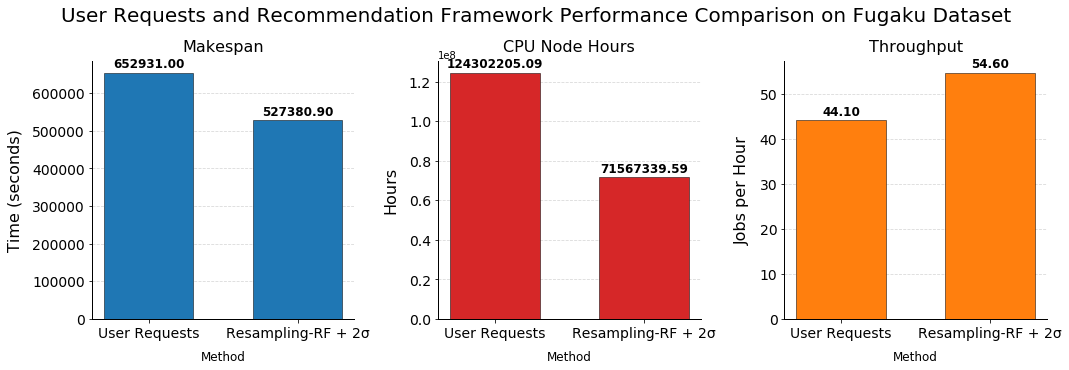

In [13]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os

types = ["act",  "multi_rf_bias"]
column_names = ['id', 'reqProc1', 'reqProc2', 'reqTime', 'run', 'wait', 'submit', 'start', 'end']
results = {
    "avg_wait": {},
    "extra_req_time": {},
    "makespan": {},
    "cpu_node_hours": {},
    "throughput": {},
    "utilization": {}
}
dataframes = {}
label_mapping = {
    'act': 'User Requests',
    'perfect': 'Perfect Prediction',
    'multi_rf_bias': 'Resampling-RF + 2\u03C3'
}

for type_name in types:
    filename = f"/projectnb/peaclab-mon/boztop/resource-allocation/jupyter_notebooks/Fugaku_{type_name}.rst"
    try:
        if not os.path.exists(filename):
            print(f"Warning: {filename} does not exist. Skipping.")
            continue
            
        df = pd.read_csv(filename, sep=";", names=column_names)
        dataframes[type_name] = df
        
        avg_wait = df['wait'].mean()
        extra_req_time = (df['reqTime'] - df['run']).sum()
        makespan = df['end'].max() - df['submit'].min()
        cpu_node_hours = (df['run'] * df['reqProc1']).sum() / 3600
        job_count = len(df)
        throughput = job_count / (makespan / 3600) if makespan > 0 else 0
        total_available_resources = makespan * df['reqProc1'].max()
        resources_used = (df['run'] * df['reqProc1']).sum()
        utilization = (resources_used / total_available_resources) * 100 if total_available_resources > 0 else 0
        
        results["avg_wait"][type_name] = avg_wait
        results["extra_req_time"][type_name] = extra_req_time
        results["makespan"][type_name] = makespan
        results["cpu_node_hours"][type_name] = cpu_node_hours
        results["throughput"][type_name] = throughput
        results["utilization"][type_name] = utilization
        
        print(f"Analyzed {type_name}: Avg Wait = {avg_wait:.2f}, Extra Time = {extra_req_time:.2f}, "
              f"Makespan = {makespan:.2f}, CPU Node Hours = {cpu_node_hours:.2f}, "
              f"Throughput = {throughput:.2f} jobs/hour, Utilization = {utilization:.2f}%")
    except Exception as e:
        print(f"Error processing {filename}: {e}")

fig, axes = plt.subplots(1,3, figsize=(15,5))
axes = axes.flatten()

# Remove gray background
fig.patch.set_facecolor('white')
for ax in axes:
    ax.set_facecolor('white')
    # Make axes visible (black)
    ax.spines['bottom'].set_color('black')
    ax.spines['left'].set_color('black')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.tick_params(colors='black')

def style_subplot(ax, title, ylabel, types_list, values, color):
    plot_labels = [label_mapping.get(t, t) for t in types_list]
    bars = ax.bar(plot_labels, values, color=color, edgecolor='black', width=0.6)
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height + 0.01*max(values),
                f'{height:.2f}', ha='center', va='bottom', fontsize=12, fontweight='bold')
    ax.set_title(title, fontsize=16, pad=10, color='black')
    ax.set_ylabel(ylabel, fontsize=16, labelpad=10, color='black')
    ax.set_xlabel('Method', fontsize=12, labelpad=10, color='black')
    ax.tick_params(axis='both', which='major', labelsize=14, colors='black')
    ax.grid(axis='y', linestyle='--', alpha=0.3, color='gray')
    return bars

# Use blue, red, and orange colors as requested
types_list = list(results["makespan"].keys())
values = list(results["makespan"].values())
style_subplot(axes[0], 'Makespan', 'Time (seconds)', types_list, values, color='#1f77b4')  # Blue

types_list = list(results["cpu_node_hours"].keys())
values = list(results["cpu_node_hours"].values())
style_subplot(axes[1], 'CPU Node Hours', 'Hours', types_list, values, color='#d62728')  # Red

types_list = list(results["throughput"].keys())
values = list(results["throughput"].values())
style_subplot(axes[2], 'Throughput', 'Jobs per Hour', types_list, values, color='#ff7f0e')  # Orange

fig.suptitle('User Requests and Recommendation Framework Performance Comparison on Fugaku Dataset', 
             fontsize=20, y=1.02, color='black')
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.subplots_adjust(hspace=0.3)
plt.show()

In [ ]:

plt.figure(figsize=(14, 10))

baseline = 'act'
metrics_to_plot = ['avg_wait', 'extra_req_time', 'makespan', 'cpu_node_hours', 'throughput', 'utilization']
metric_labels = ['Avg Wait Time', 'Extra Time', 'Makespan', 'CPU Hours', 'Throughput', 'Utilization']

normalized_data = {}

for metric in metrics_to_plot:
    normalized_data[metric] = {}
    baseline_value = results[metric].get(baseline, 1)
    if baseline_value == 0:
        continue
    for type_name in types:
        if type_name in results[metric]:
            if metric in ['throughput', 'utilization']:
                normalized_data[metric][type_name] = (results[metric][type_name] / baseline_value - 1) * 100
            else:
                normalized_data[metric][type_name] = (1 - results[metric][type_name] / baseline_value) * 100

bar_width = 0.2
index = np.arange(len(metrics_to_plot))

colors = {
    'act': '#3498db',
    'perfect': '#2ecc71',
    'multi_rf_bias': '#e74c3c'
}

for i, type_name in enumerate([t for t in types if t != baseline]):
    values = [normalized_data[metric].get(type_name, 0) for metric in metrics_to_plot]
    plt.bar(index + i * bar_width, values, bar_width, 
            label=label_mapping.get(type_name, type_name),
            color=colors.get(type_name, 'gray'))

plt.xlabel('Performance Metrics', fontsize=14)
plt.ylabel('Percentage Change Relative to User Requests (%)', fontsize=14)
plt.title('Relative Performance Comparison', fontsize=18)
plt.xticks(index + bar_width, metric_labels, fontsize=12)
plt.legend(fontsize=12)

plt.axhline(y=0, color='k', linestyle='-', alpha=0.3)
plt.grid(axis='y', linestyle='--', alpha=0.7)

for i, type_name in enumerate([t for t in types if t != baseline]):
    values = [normalized_data[metric].get(type_name, 0) for metric in metrics_to_plot]
    for j, v in enumerate(values):
        if abs(v) > 1:
            plt.text(j + i * bar_width, v + (5 if v >= 0 else -12),
                    f"{v:.1f}%", ha='center', va='bottom' if v >= 0 else 'top',
                    fontsize=10, rotation=45 if abs(v) > 20 else 0)

plt.tight_layout()
plt.show()

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def create_separate_pie_charts(df_dict):
    ratio_bins = {
        '<0.75': lambda r: (r < 0.75),
        '0.75-0.85': lambda r: (r >= 0.75) & (r < 0.85),
        '0.85-0.95': lambda r: (r >= 0.85) & (r < 0.95),
        '0.95-1.0': lambda r: (r >= 0.95) & (r < 1.0),
        '1.0-1.05': lambda r: (r >= 1.0) & (r <= 1.05),
        '1.05-1.1': lambda r: (r > 1.05) & (r <= 1.1),
        '1.1-1.15': lambda r: (r > 1.1) & (r <= 1.15),
        '> 1.15 ': lambda r: (r > 1.15)
    }

    colors = ['#d73027', '#f46d43', '#fdae61', '#a6d96a', '#66bd63', '#3288bd', '#5e4fa2', '#9e0142']
    fig_dict = {}

    for metric, configs in df_dict.items():
        num_configs = len(configs)
        fig, axs = plt.subplots(1, num_configs, figsize=(5 * num_configs, 5))
        axs = np.atleast_1d(axs)

        for j, (config, df) in enumerate(configs.items()):
            ax = axs[j]

            if df is None or 'pred' not in df.columns or 'act' not in df.columns:
                ax.set_title(f"{metric} - {config}\n(No Data)", fontsize=12)
                ax.axis('off')
                continue

            df = df.copy()
            df['ratio'] = df['pred'] / df['act']
            counts = {k: df[cond(df['ratio'])].shape[0] for k, cond in ratio_bins.items()}
            total = sum(counts.values())
            percentages = [v / total * 100 if total > 0 else 0 for v in counts.values()]
            
            wedges, _, autotexts = ax.pie(
                percentages,
                labels=None,
                autopct='%1.1f%%' if total > 0 else None,
                startangle=90,
                colors=colors,
                pctdistance=0.85,
                wedgeprops=dict(width=0.5, edgecolor='w')
            )
            ax.set_aspect('equal')
            ax.set_title(f"{metric} - {config}", fontsize=14)

        # Add legend below the row
        fig.legend(
            wedges,
            list(ratio_bins.keys()),
            title="Prediction/Actual Ratio",
            loc="lower center",
            bbox_to_anchor=(0.5, -0.01),
            ncol=4,
            fontsize=12
        )

        plt.tight_layout()
        plt.subplots_adjust(bottom=0.2)
        fig.suptitle(f"Prediction Accuracy Distribution for '{metric}'", fontsize=18, y=1.05)
        fig_dict[metric] = fig

    return fig_dict


In [ ]:
figures = create_separate_pie_charts(df_dict)

# To show them:
for metric, fig in figures.items():
    fig.show()  # or plt.show() in a loop


# Tobit Model Experiment

# Baseline Experiment

In [ ]:
for start_date, end_date in date_pairs:
    
    df_slice = df[(df['edt'] >= start_date) & (df['edt'] < end_date)]
    train_df, test_df = train_test_split(df_slice, test_size=0.2, random_state=33)

    # Baseline Experiment
    #sourced from: https://github.com/NREL/eagle-jobs/blob/master/python_scripts/EVAL_FinalModel.py
    model, biases = train_eagle_xgboost(train_df, train_features, target_feature)
    
    for bias_type in bias_types:
        test_eagle_xgboost(test_df, model, biases, bias_type, train_features, target_feature, user_req_feature, f'/projectnb/peaclab-mon/boztop/resource-allocation/exp_results/fugaku/obj_changed/cpu_pred/window_size={window_size}/fugaku_baseline_bias_{bias_type}_{target_feature}_window_{window_size}_days_{start_date}.pkl')
    

# Execution Time Prediction Experiments

In [ ]:
for start_date, end_date in date_pairs:
    
    df_slice = df[(df['edt'] >= start_date) & (df['edt'] < end_date)]
    train_df, test_df = train_test_split(df_slice, test_size=0.2, random_state=33)

    print("[INFO] Creating sub-dataframes and clustering...")
    sub_dataframes, cluster_centers = create_sub_dataframes(
        df=train_df, 
        selected_features=train_features, 
        n_clusters=4 #!!!!!!!!!! 
    )


    print("[INFO] Training plain models (XGBoost and RandomForest)...")
    xgb_plain_models, xgb_plain_biases = train_model_per_cluster(
        sub_dataframes, train_features, target_feature, 'xgboost')
    rf_plain_models, rf_plain_biases = train_model_per_cluster(
        sub_dataframes, train_features, target_feature, 'rf')
    print("[INFO] Plain models training completed.")


    for bias_type in bias_types:
        print(f"[INFO] Evaluating with bias type: {bias_type}...")

        test_model_per_cluster(
            test_df, train_features, target_feature, user_req_feature, cluster_centers,
            xgb_plain_models, xgb_plain_biases, bias_type, 'xgboost',
            f'/projectnb/peaclab-mon/boztop/resource-allocation/exp_results/fugaku/obj_changed/cpu_pred/window_size={window_size}/fugaku_clustering_xgb_bias_{bias_type}_{target_feature}_window_{window_size}_days_{start_date}.pkl'
        )

        test_model_per_cluster(
            test_df, train_features, target_feature, user_req_feature, cluster_centers,
            rf_plain_models, rf_plain_biases, bias_type, 'rf',
            f'/projectnb/peaclab-mon/boztop/resource-allocation/exp_results/fugaku/obj_changed/cpu_pred/window_size={window_size}/fugaku_clustering_rf_bias_{bias_type}_{target_feature}_window_{window_size}_days_{start_date}.pkl'
        )


    print("[INFO] Training resampled models (XGBoost and RandomForest)...")
    xgb_resampled_models, xgb_resampled_biases = train_model_per_cluster(
        sub_dataframes, train_features, target_feature, 'xgboost',resampling=True)
    rf_resampled_models, rf_resampled_biases = train_model_per_cluster(
        sub_dataframes, train_features, target_feature, 'rf',resampling=True)
    print("[INFO] Resampled models training completed.")
    
    for bias_type in bias_types:
        print(f"[INFO] Evaluating with bias type: {bias_type}...")

        test_model_per_cluster(
            test_df, train_features, target_feature, user_req_feature, cluster_centers,
            xgb_resampled_models, xgb_resampled_biases, bias_type, 'xgboost',
            f'/projectnb/peaclab-mon/boztop/resource-allocation/exp_results/fugaku/obj_changed/cpu_pred/window_size={window_size}/fugaku_resampled_xgb_bias_{bias_type}_{target_feature}_window_{window_size}_days_{start_date}.pkl'
        )

        test_model_per_cluster(
            test_df, train_features, target_feature, user_req_feature, cluster_centers,
            rf_resampled_models, rf_resampled_biases, bias_type, 'rf',
            f'/projectnb/peaclab-mon/boztop/resource-allocation/exp_results/fugaku/obj_changed/cpu_pred/window_size={window_size}/fugaku_resampled_rf_bias_{bias_type}_{target_feature}_window_{window_size}_days_{start_date}.pkl'
        ) 
        
        
        
        

# Observe Predictions

In [ ]:
start_time = '2024-04-05'
end_time = '2024-04-30'

start_dates = pd.date_range(start=start_time, end=end_time, freq='7D')
window_sizes = [7, 14]

target_feature = ['cnumut'] 
models = ['baseline', 'clustering_xgb','clustering_rf', 'resampled_xgb', 'resampled_rf']

bias_types = ['none', 'two_sigma']


results = {}

for start_date in start_dates:
    results[start_date] = {}
    
    for window_size in window_sizes:
        results[start_date][window_size] = {}

        for model in models:
            results[start_date][window_size][model] = {}

            for bias_type in bias_types:
                results[start_date][window_size][model][bias_type] = {}

                file_path = f'/projectnb/peaclab-mon/boztop/resource-allocation/exp_results/fugaku/obj_changed/cpu_pred/window_size={window_size}/fugaku_{model}_bias_{bias_type}_{target_feature}_window_{window_size}_days_{start_date}.pkl' 
                results[start_date][window_size][model][bias_type] = pd.read_pickle(file_path) 
                
start_dates = pd.date_range(start=start_time, end=end_time, freq='3D')
window_sizes = [3]



for start_date in start_dates:
    results[start_date] = {}
    
    for window_size in window_sizes:
        results[start_date][window_size] = {}

        for model in models:
            results[start_date][window_size][model] = {}

            for bias_type in bias_types:
                results[start_date][window_size][model][bias_type] = {}

                file_path = f'/projectnb/peaclab-mon/boztop/resource-allocation/exp_results/fugaku/obj_changed/cpu_pred/window_size={window_size}/fugaku_{model}_bias_{bias_type}_{target_feature}_window_{window_size}_days_{start_date}.pkl' 
                results[start_date][window_size][model][bias_type] = pd.read_pickle(file_path) 
                
              



In [ ]:
import math 
models = ['baseline', 'clustering_xgb', 'clustering_rf', 'resampled_xgb', 'resampled_rf']
bias_types = ['none', 'two_sigma']
start_dates = pd.date_range(start=start_time, end=end_time, freq='3D')


for model in models:
    for bias in bias_types:
        total_underpred = 0
        total_jobs = 0
        total_user_req = 0
        total_pred = 0
        
        for start_date in start_dates:
            df = results[start_date].get(3, {}).get(model, {}).get(bias)
            if df is None:
                continue

            df = df.copy()
            
            
            df['pred'] = df['pred'].apply(lambda x: math.ceil(x) if pd.notna(x) else x)

            underpredictions = df[df['pred'] < df['act']]
            total_underpred += len(underpredictions)
            total_jobs += len(df)

            user_overpred = df[df['act'] < df['req']]
            total_user_req += (user_overpred['req'] - user_overpred['act']).sum()

            overpred = df[df['act'] < df['pred']]
            total_pred += (overpred['pred'] - overpred['act']).sum()


        # Compute success and underprediction ratios
        if total_jobs > 0:
            success_rate = 100 * (1 - total_underpred / total_jobs)
            underpred_ratio = 100 * (total_underpred / total_jobs)
        else:
            success_rate = 0
            underpred_ratio = 0

        print(f"For Model {model}, Bias {bias}:")
        print(f" - Underprediction Ratio: {underpred_ratio:.2f}%")



In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Define models and time range
models = ['baseline', 'clustering_xgb', 'clustering_rf', 'resampled_xgb', 'resampled_rf']
start_dates = pd.date_range(start=start_time, end=end_time, freq='3D')

# Define model colors and labels
model_colors = {
    'baseline': 'blue',
    'clustering_xgb': '#FFAB7D',
    'clustering_rf': 'green',
    'resampled_xgb': 'purple',
    'resampled_rf': 'orange'
}
custom_labels = {
    'baseline': 'Baseline',
    'clustering_xgb': 'Clustering-XGB',
    'clustering_rf': 'Clustering-RF',
    'resampled_xgb': 'Resampled-XGB',
    'resampled_rf': 'Resampled-RF'
}


data_list = []

for model in models:
    for start_date in start_dates:
        df = results[start_date].get(3, {}).get(model, {}).get('two_sigma')
        if df is None:
            continue
        
        df = df.copy()
        df['overestimation_factor'] = df['pred'] / df['act']
        df['user_overestimation_factor'] = df['req'] / df['act']
        
        model_data = pd.DataFrame({
            'overestimation_factor': df['overestimation_factor'],
            'model': model
        })
        data_list.append(model_data)

overestimation_df = pd.concat(data_list, ignore_index=True)

plt.figure(figsize=(10, 6))

for model in models:
    model_data = overestimation_df[overestimation_df['model'] == model]['overestimation_factor']
    sns.kdeplot(model_data, color=model_colors[model], label=custom_labels[model], log_scale=True, fill=True, alpha=0.5)

user_overestimation_data = df['user_overestimation_factor']
sns.kdeplot(user_overestimation_data, color='red', label='User Request Overestimation', log_scale=True, fill=True, alpha=0.5, linestyle='dashed')

plt.axvline(x=1, color='red', linestyle='dashed', linewidth=2, label='Perfect Prediction (x=1)')
plt.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.7)


plt.xlabel('Overestimation Factor (Predicted / Actual)',fontsize=14)
plt.ylabel('Density',fontsize=14)
plt.title('Fugaku Dataset Maximum Memory Size (Bytes) Overestimation Results', fontsize=16)
plt.legend()
plt.show()




In [ ]:
plot_data = []

for start_date, window_dict in results.items():
    for window_size, model_dict in window_dict.items():
        for model, bias_dict in model_dict.items():
            for bias, df in bias_dict.items():
                if df is not None and 'pred' in df.columns and 'act' in df.columns:
                
                    rmse = np.sqrt(np.mean((df['pred'] - df['act']) ** 2))
                    mae = np.mean(np.abs(df['pred'] - df['act']))

                    underpredictions = df[df['pred'] < df['act']]
                    num_underpredictions = len(underpredictions)
                    total_predictions = len(df)
                    underpred_ratio = 100 * num_underpredictions / total_predictions

                    # Compute the mean and std dev of underprediction amounts
                    underpred_amounts = (underpredictions['act'] - underpredictions['pred'])
                    total_underpred_amount = underpred_amounts.sum() / 3600
                    mean_underpred_amount = underpred_amounts.mean() / 3600
                    std_underpred_amount = underpred_amounts.std() / 3600

                    plot_data.append({
                        'Window Size': window_size, 
                        'Model': model, 
                        'Bias': bias, 
                        'RMSE': rmse, 
                        'MAE': mae, 
                        'UR': underpred_ratio, 
                        'UR_total(hours)': total_underpred_amount,
                        'UR_mean(hours)': mean_underpred_amount, 
                        'UR_std(hours)': std_underpred_amount
                    })
                
                else:
                    print(f"  Skipping Model: {model} due to missing columns")

# Convert to DataFrame
plot_df = pd.DataFrame(plot_data)


average_metrics = plot_df.groupby(['Window Size', 'Model', 'Bias']).mean().reset_index()


In [ ]:
import os
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.colors as mcolors

base_colors = sns.color_palette("muted", 5)

lighter_colors = [mcolors.to_rgb(c) for c in base_colors]
lighter_colors = [(r + 0.5*(1-r), g + 0.5*(1-g), b + 0.5*(1-b)) for r, g, b in lighter_colors]
custom_palette = [color for pair in zip(lighter_colors, base_colors) for color in pair]

plot_df["Model_Bias"] = plot_df["Model"] + " - " + plot_df["Bias"]

custom_labels = {
    'baseline - none': 'Single-XGB',
    'baseline - two_sigma': r'Single-XGB + $2\sigma$',
    'clustering_xgb - none': 'Clustering-XGB',
    'clustering_xgb - two_sigma': r'Clustering-XGB + $2\sigma$',
    'clustering_rf - none': 'Clustering-RF',
    'clustering_rf - two_sigma': r'Clustering-RF + $2\sigma$',
    'resampled_xgb - none': 'Resampling-XGB',
    'resampled_xgb - two_sigma': r'Resampling-XGB + $2\sigma$',
    'resampled_rf - none': 'Resampling-RF',
    'resampled_rf - two_sigma': r'Resampling-RF + $2\sigma$',
}

fig, axes = plt.subplots(1, 3, figsize=(14, 6), sharex=True)

sns.boxplot(
    data=plot_df,   
    x="Window Size",   
    y="UR",    
    hue="Model_Bias",   
    palette=custom_palette,
    ax=axes[0]
)
axes[0].set_xlabel("Window Size", fontsize=14)
axes[0].set_ylabel("Underprediction Ratio (%)", fontsize=14)


sns.boxplot(
    data=plot_df,   
    x="Window Size",   
    y="UR_mean(hours)",    
    hue="Model_Bias",   
    palette=custom_palette,
    ax=axes[1]
)
axes[1].set_xlabel("Window Size", fontsize=14)
axes[1].set_ylabel("Mean Underprediction Amount (Hours)", fontsize=14)


sns.boxplot(
    data=plot_df,   
    x="Window Size",   
    y="UR_std(hours)",    
    hue="Model_Bias",   
    palette=custom_palette,
    ax=axes[2]
)
axes[2].set_xlabel("Window Size", fontsize=14)
axes[2].set_ylabel("Underprediction Amount Std Dev (Hours)", fontsize=14)



fig.suptitle("Execution Time Underprediction Analysis on Fugaku Dataset", fontsize=18)

handles, labels = axes[0].get_legend_handles_labels()

custom_labels_list = [custom_labels.get(label, label) for label in labels]

fig.legend(handles, custom_labels_list, loc='upper center', bbox_to_anchor=(0.52, 1.1), ncol=5, fontsize=12)

axes[0].legend_.remove()
axes[1].legend_.remove()
axes[2].legend_.remove()

plt.tight_layout(rect=[0, 0, 1, 0.95])

plot_name = 'boxplot_fugaku.svg'
file_path = os.path.join('/projectnb/peaclab-mon/boztop/resource-allocation/plots', plot_name)
plt.savefig(file_path, format="svg", dpi=300, bbox_inches='tight')

plt.show()


In [ ]:
# Visualize underprediction distribution
start_dates = pd.date_range(start=start_time, end=end_time, freq='3D')

models = ['baseline', 'clustering_xgb', 'resampled_xgb','clustering_rf', 'resampled_rf']
fig, axes = plt.subplots(1, len(models), figsize=(15, 4), sharey=True)

bounds = [0, 60*10, 60*60, 60*60*4, 60*60*12, 60*60*24, 60*60*24*10]
colors = plt.cm.plasma(np.linspace(0, 1, len(bounds) - 1))
line_colors = colors.copy()


for ax, model in zip(axes, models):
    ax.set_title(f'{model} Error Distribution')
    median_errors = {bound: [] for bound in bounds[:-1]}  # Store median errors for each bin
    total_underpred = 0
    total_jobs = 0

    for start_date in start_dates:
        df = results[start_date].get(3, {}).get(model, {}).get('two_sigma')
        if df is None:
            continue
        df = df.copy()
        underpredictions = df[df['pred'] < df['act']].copy()
        df.loc[:, 'error'] = df['act'] - df['pred']
        df.loc[:, 'abs_error'] = abs(df['error'])
        
        for i, bound in enumerate(bounds[:-1]):
            l_bound = bound
            r_bound = bounds[i + 1]
            color = colors[i]
            line_color = line_colors[i]

            error_sample = df[df.act.between(l_bound, r_bound, inclusive='right')].abs_error / 60
            ax.hist(error_sample, bins=np.logspace(-3, 4, 50), color=color, alpha=0.8)

            med_err = error_sample.median()
            if not np.isnan(med_err):  # Store median error only if valid
                median_errors[bound].append(med_err)

    # Plot median error lines after processing all start dates
    for i, bound in enumerate(bounds[:-1]):
        if median_errors[bound]:  # If there are valid medians
            med_err_final = np.median(median_errors[bound])  # Take median of medians
            med_err_label = 'minutes'
            if med_err_final > 60:
                med_err_final /= 60
                med_err_label = 'hours'

            # Format bounds label
            bound_label = '('
            for bound in (bounds[i], bounds[i + 1]):
                if bound < 60*60:
                    new_bound = f"{bound//60}m"
                elif bound < 60*60*24:
                    new_bound = f"{bound//(60*60)}h"
                else:
                    new_bound = f"{bound//(24*60*60)}d"
                bound_label += f"{new_bound}, "
            bound_label = bound_label[:-2] + ']'

            ax.vlines(med_err_final, 0, 250000, linestyle='--', color=line_colors[i], 
                      label=f'{bound_label} Med Err: {med_err_final:.1f} {med_err_label}')
    
    ax.set_xscale('log')
    ax.set_xlim(0.1, 10000)
    ax.set_ylim([0, 500])
    ax.legend(loc='upper left', prop={'family': 'DejaVu Sans Mono'})
    ax.set_xlabel('Absolute Error (minutes)',fontsize=14)
    if ax == axes[0]:
        ax.set_ylabel('Number of Jobs',fontsize=14)

plt.suptitle(r'Execution Time Absolute Error Results on Fugaku Dataset (with bias=2$\sigma$)', y=1.05, fontsize=16)
plt.tight_layout()
plt.show()
